# KIAM 8

## Task 1: Exploratory Data Analysis and Data Preprocessing

Objective: Understand the structure, content, and quality of the complaint data and prepare it for the RAG pipeline.

In [1]:
# Import Essential Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Sub Tasks

#### ●	Load the full CFPB complaint dataset.

In [2]:
# Load the dataset
df = pd.read_csv("../data/raw/complaints.csv", low_memory=False)

# Initial inspection
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (9609797, 18)

Column names:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

First few rows:
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt 

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


#### ●	Perform an initial EDA to understand the data.
        ○	Analyze the distribution of complaints across different Products.
        ○	Calculate and visualize the length (word count) of the Consumer complaint narrative. Are there very short or very long narratives?
        ○	Identify the number of complaints with and without narratives.



Product Distribution:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Name: count, dtype: int64


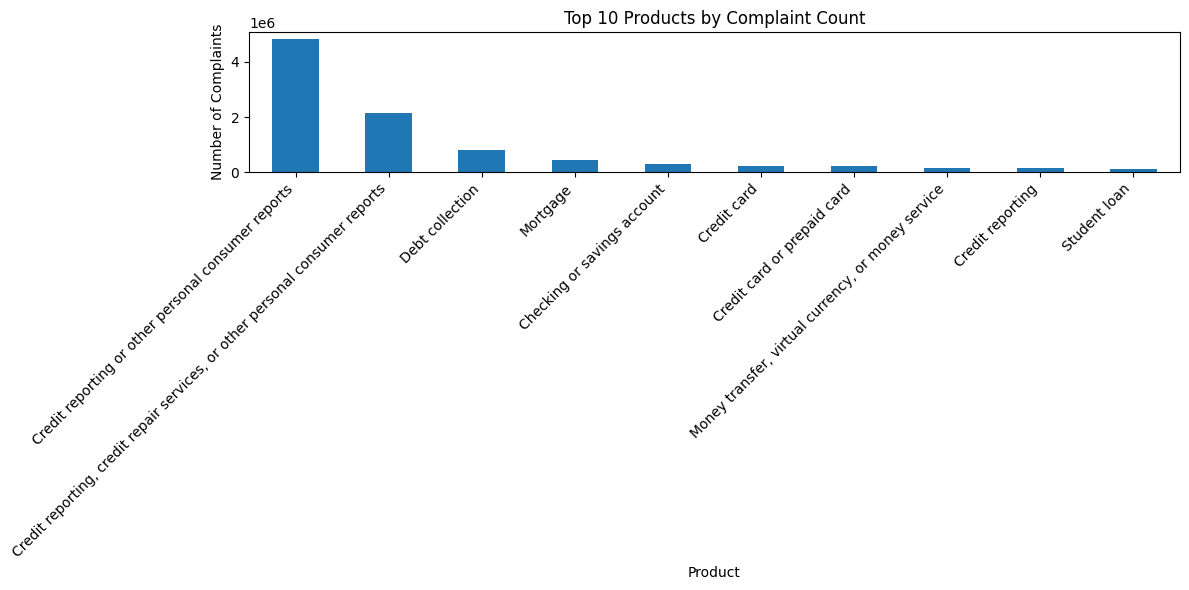

In [4]:
# Filter for the 5 specified products
target_products = [
    'Credit card',
    'Credit card or prepaid card',
    'Payday loan, title loan, or personal loan',
    'Checking or savings account',
    'Money transfer, virtual currency, or money service'
]

# Analyze product distribution
print("\nProduct Distribution:")
product_counts = df['Product'].value_counts()
print(product_counts.head(10))

# Visualize product distribution
plt.figure(figsize=(12, 6))
product_counts.head(10).plot(kind='bar')
plt.title('Top 10 Products by Complaint Count')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/product_distribution.png')
plt.show()


Narrative Length Statistics:
count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64

Complaints with narratives: 2980756
Complaints without narratives: 6629041


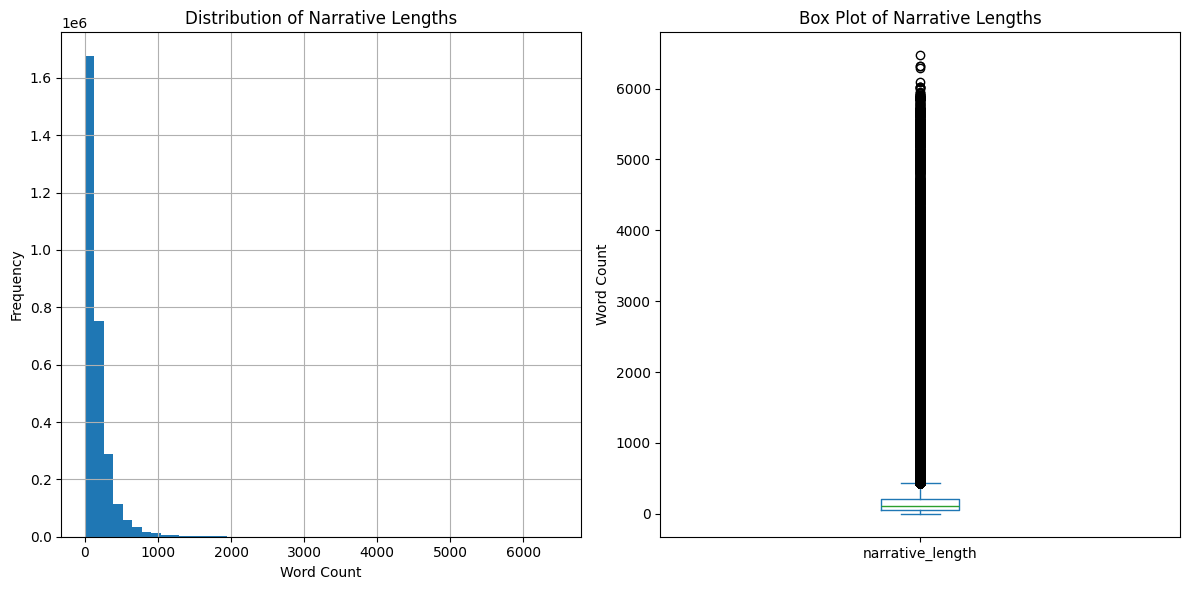

In [9]:
# Analyze narrative length
df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(
    lambda x: len(x.split()) if x != 'nan' else 0
)

# Statistics on narrative length
print("\nNarrative Length Statistics:")
print(df['narrative_length'].describe())

# Identify complaints with/without narratives
has_narrative = df['Consumer complaint narrative'].notna()
print(f"\nComplaints with narratives: {has_narrative.sum()}")
print(f"Complaints without narratives: {(~has_narrative).sum()}")

# Visualize narrative length distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[df['narrative_length'] > 0]['narrative_length'].hist(bins=50)
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df[df['narrative_length'] > 0]['narrative_length'].plot(kind='box')
plt.title('Box Plot of Narrative Lengths')
plt.ylabel('Word Count')
plt.tight_layout()
plt.savefig('figures/narrative_length_analysis.png')
plt.show()

#### ●	Filter the dataset to meet the project's requirements:
        ○	Include only records for the five specified products: Credit card, Personal loan, Savings account, and Money transfers.
        ○	Remove any records with empty Consumer complaint narrative fields.


In [5]:
# Standardize product names for the 5 categories
product_mapping = {
    'Credit card': 'Credit Card',
    'Credit card or prepaid card': 'Credit Card',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Personal Loan',
    'Checking or savings account': 'Savings Account',
    'Money transfer, virtual currency, or money service': 'Money Transfers',
    'Money transfer': 'Money Transfers'
}

# Filter dataset
df_filtered = df[df['Product'].isin(product_mapping.keys())].copy()
df_filtered['product_category'] = df_filtered['Product'].map(product_mapping)

# Remove rows without narratives
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notna()].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"\nProduct category distribution:")
print(df_filtered['product_category'].value_counts())



Filtered dataset shape: (452975, 19)

Product category distribution:
product_category
Credit Card        189334
Savings Account    140319
Money Transfers     97188
Personal Loan       26134
Name: count, dtype: int64


In [6]:
# Add Scripts Path to environment to import pre-defined helper scripts

import os
import sys

cwd = os.getcwd()
scripts_path = os.path.join(cwd,'..','src')
scripts_abs_path = os.path.abspath(scripts_path)

if scripts_abs_path not in sys.path and os.path.isdir(scripts_abs_path):
    sys.path.append(scripts_abs_path)
    print('Scripts Path Added to Enviornment')
else:
    print('Scripts path is invalid or already added to environment')

Scripts Path Added to Enviornment


In [7]:
from  data_cleaning import clean_text

#### ●	Clean the text narratives to improve embedding quality. This may include:
        ○	Lowercasing text.
        ○	Removing special characters or boilerplate text (e.g., "I am writing to file a complaint...").
        ○	(Optional) Consider other text normalization techniques. 


In [8]:
# Apply cleaning
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# Remove very short narratives (less than 10 words)
df_filtered['word_count'] = df_filtered['cleaned_narrative'].apply(lambda x: len(x.split()))
df_filtered = df_filtered[df_filtered['word_count'] >= 10].copy()

print(f"\nFinal dataset shape after cleaning: {df_filtered.shape}")

# Save cleaned dataset
output_columns = [
    'Complaint ID',
    'Product',
    'product_category',
    'Sub-product',
    'Issue',
    'Sub-issue',
    'Company',
    'State',
    'Date received',
    'cleaned_narrative'
]

df_filtered[output_columns].to_csv('../data/processed/filtered_complaints.csv', index=False)
print("\nCleaned dataset saved to ../data/processed/filtered_complaints.csv")


Final dataset shape after cleaning: (450596, 21)

Cleaned dataset saved to ../data/processed/filtered_complaints.csv
